In [1]:
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals
import pints.toy as toy
import pints
import numpy as np
import logging
import math
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
from numpy import inf
import copy 
import pickle
import time
import CMA as CMA

In [2]:
log_pdf = pints.toy.GaussianLogPDF([2, 4], [[1, 0], [0, 3]])

In [7]:
from matplotlib.patches import Ellipse

def CMA_on_Slice(opt, 
                 problem, 
                 prior_sampler, 
                 sampler, 
                eval_fun=['KL']):
    
    best_fxs = []
    best_xs = []
    
    best_fx = np.inf
    best_x = 0
    
    for i in range(1):
        
        xs = opt.ask()
        fxs = []
        for x in xs:
            our_x = np.copy(x) 
            mcmc = pints.MCMCController(problem, 1, 
                                        prior_sampler, 
                                        method=sampler)
            mcmc.set_log_to_screen(False)
            for s in mcmc.samplers():
                s.set_w(our_x)
            mcmc.set_max_iterations(250)
            full_chains = mcmc.run()
            
            fx = 0
            if 'KL' in eval_fun:
                kl = 0
                chains = full_chains[:, 200:]
                for chain in chains:
                    kl += log_pdf.kl_divergence(chain)
                fx += kl/len(chains)                
            
            fxs.append(log_pdf.kl_divergence(chains[0]))
        opt.tell(fxs)
        
        best_fxs.append(opt.fbest())
        best_xs.append(opt.xbest())
        
        if opt.fbest() < best_fx:
            best_fx = opt.fbest()
            best_x = opt.xbest()
    
    print(best_fx)
    print(best_x)
    
    return best_fxs, best_xs

In [8]:
prior_of_sample_task = [[5, 4]]
prior_of_optimize_task = [0.001, 0.001]

boundary = pints.RectangularBoundaries([0, 0], [200, 200])
cma = CMA.CMAES(prior_of_optimize_task, boundaries=boundary)
sampler = pints.SliceHyperrectanglesMCMC

fxs, xs =  CMA_on_Slice(cma, log_pdf, prior_of_sample_task, sampler)

ValueError: Width ``w`` must be positive for
                            interval expansion.

In [5]:
print(issubclass(pints.SliceHyperrectanglesMCMC, pints.MCMCSampler))
sampler = pints.SliceHyperrectanglesMCMC
print(issubclass(sampler, pints.MCMCSampler))

True
True


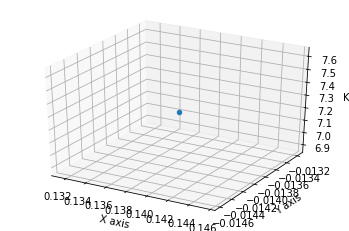

In [6]:
# Get the grid values
our_xs = np.array(xs)

X = np.array(our_xs[:,0])
Y = np.array(our_xs[:,1])
Z = np.array(fxs)


# Plot the graph
fig = plt.figure()


ax = fig.gca(projection='3d')


for i in range(len(X)-1):
    ax.plot([X[i],X[i+1]], [Y[i], Y[i+1]], [Z[i], Z[i+1]])


ax.scatter(X, Y, Z)
ax.plot([X[-1]], [Y[-1]], [Z[-1]], markerfacecolor='black', markersize=100)

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('KL')

plt.show()